In [4]:
from main import MyViT
!pip install wandb


In [5]:
import numpy as np
import os
from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
import wandb

In [6]:
wandb.login()
run = wandb.init(project="VIT_WANDB_MNIST",
                 config={
                         "learning_rate": 0.0005,
                         "dataset": "MNIST"})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: phongminhphan (phongminhphan-vietnam-national-university-hanoi). Use `wandb login --relogin` to force relogin


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
transform = ToTensor()
train_set = MNIST(root='./data', train=True, transform=transform, download=True)
test_set = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [9]:
# tranfer list of images to list of one-dimension vectors
def patchify(images, n_patches):
    n , c , h, w = images.shape  
    patches = torch.zeros(n, n_patches **2 , h * w * c // n_patches ** 2)
    patch_size = h // n_patches
    for id, image in enumerate(images):
        for i in range(n_patches):
            for j in range(patch_size ):
                patch = image[:, i * patch_size : (i + 1) * patch_size ,j * patch_size : (j + 1) * patch_size ]
                patches[id,i* n_patches + j] = patch.flatten()
    return patches

# Not in the paper, use to help model know the location of patch in the origin images
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result              

In [10]:
class MyViT(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(MyViT, self).__init__()
        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        #  Positional embedding (why use register_buffer, because postion parameter do no learnable but can easy compute by formula
        self.register_buffer("positional_embeddings",get_positional_embeddings(n_patches**2 + 1, hidden_d),persistent=False,)

        #  Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        #  Classification MLPk
        self.mlp = nn.Sequential(nn.Linear(self.hidden_d, out_d), nn.Softmax(dim=-1))

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
        # Getting the classification token only
        out = out[:, 0]

        return self.mlp(out)  # Map to output dimension, output category distribution


In [11]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])


class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [12]:
model = MyViT(chw=(1, 28, 28),n_patches=7)
x = torch.randn(7, 1, 28, 28) # Dummy images
print(model(x)) # torch.Size([7, 49, 16])

tensor([[0.1252, 0.0454, 0.1185, 0.0180, 0.2779, 0.0663, 0.0951, 0.1341, 0.0968,
         0.0227],
        [0.1242, 0.0421, 0.1151, 0.0174, 0.2894, 0.0627, 0.0892, 0.1334, 0.1032,
         0.0233],
        [0.1297, 0.0461, 0.1125, 0.0187, 0.2686, 0.0664, 0.0904, 0.1389, 0.1059,
         0.0227],
        [0.1270, 0.0448, 0.1115, 0.0183, 0.2755, 0.0659, 0.0894, 0.1390, 0.1054,
         0.0231],
        [0.1297, 0.0430, 0.1083, 0.0175, 0.2820, 0.0638, 0.0880, 0.1367, 0.1079,
         0.0230],
        [0.1253, 0.0418, 0.1178, 0.0174, 0.2861, 0.0620, 0.0882, 0.1339, 0.1047,
         0.0227],
        [0.1277, 0.0430, 0.1103, 0.0174, 0.2819, 0.0637, 0.0913, 0.1379, 0.1035,
         0.0231]], grad_fn=<SoftmaxBackward0>)


In [13]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc="Training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        train_loss += loss.detach().cpu().item() / len(train_loader)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss

def test(model, test_loader,criterion, device):
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)

    return test_loss, correct / total 

In [14]:
model = MyViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
N_EPOCHS= 10  # Increased epochs to demonstrate early stopping
LR = 0.005
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()

best_accuracy = 0.0
patience = 3
epochs_without_improvement = 0
def trainer():
    
    if os.path.exists("best_model.pth"):
        print("Loading best model from previous training...")
        model.load_state_dict(torch.load("best_model.pth"))
        # Evaluate the loaded model to get its accuracy
        test_loss, best_accuracy = test(model, test_loader, criterion, device)
        print(f"Loaded model test loss: {test_loss:.2f}")
        print(f"Loaded model test accuracy: {best_accuracy * 100:.2f}%")
    for epoch in range(N_EPOCHS):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

        test_loss, test_accuracy = test(model, test_loader, criterion, device)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {test_accuracy * 100:.2f}%")
        wandb.log({
                "train_loss": train_loss,
                "test_loss": test_loss,
                "test_accuracy": test_accuracy
            })

        # Early stopping and best model saving
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered!")
                break
        


In [15]:
# trainer()

In [16]:
model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_accuracy = test(model, test_loader, criterion, device)
print(f"Final test loss (best model): {test_loss:.2f}")
print(f"Final test accuracy (best model): {test_accuracy * 100:.2f}%")


/tmp/ipykernel_75967/2230190768.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
                                     

Final test loss (best model): 1.70
Final test accuracy (best model): 76.25%


Hình ảnh thứ 7085:
Nhãn thực tế: 0
Nhãn dự đoán: 0


/tmp/ipykernel_75967/2317978726.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


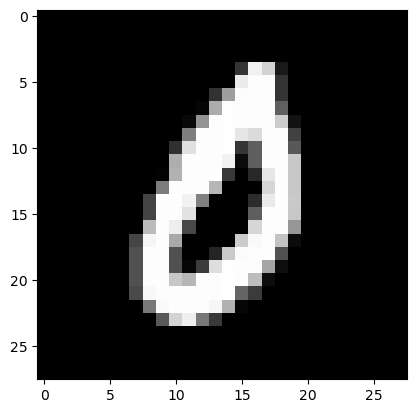

Hình ảnh thứ 2208:
Nhãn thực tế: 5
Nhãn dự đoán: 5


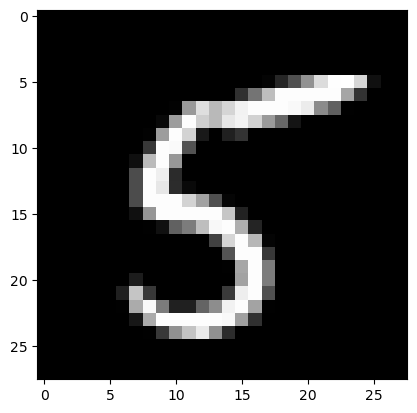

Hình ảnh thứ 6741:
Nhãn thực tế: 9
Nhãn dự đoán: 0


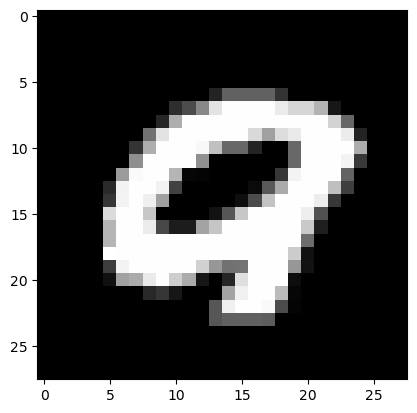

Hình ảnh thứ 5427:
Nhãn thực tế: 4
Nhãn dự đoán: 4


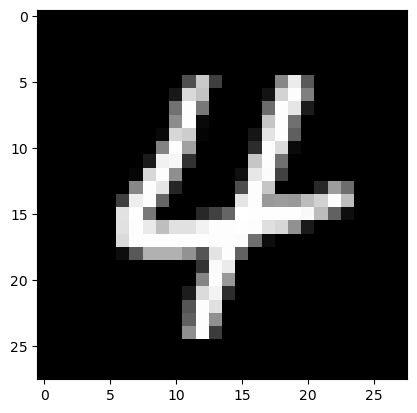

Hình ảnh thứ 3754:
Nhãn thực tế: 7
Nhãn dự đoán: 7


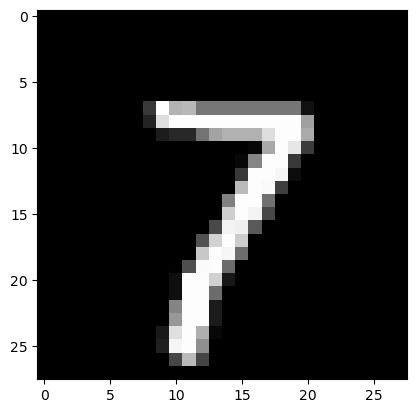

In [19]:
from matplotlib import pyplot as plt, transforms
from PIL import Image


# def predict(image_path):
#     # Load and preprocess the image
#     
#     image = Image.open(image_path).convert('')  # Convert to grayscale
#     image = Image.eval(image, lambda x: 255 - x)
# 
#     image = image.resize((28, 28))
#     plt.imshow(image)
#     plt.axis('off')
#     plt.show()
#     transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#     ])
# 
#     image = transform(image).unsqueeze(0)
# 
#     # Move tensor to the device
#     image = image.to(device)
# 
#     # Make prediction
#     model.load_state_dict(torch.load("best_model.pth"))
#     model.eval()  # Set model to evaluation mode
#     with torch.no_grad():
#         output = model(image)
#         _, predicted = torch.max(output.data, 1)
#         predicted_class = predicted.item()
# 
#     return predicted_class
# 

# Example usage:

def predict(model, image, device):
    
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return predicted.item()
model.load_state_dict(torch.load("best_model.pth"))

# Chọn một số hình ảnh ngẫu nhiên từ test_set
num_samples = 5
indices = torch.randint(0, len(test_set), (num_samples,))

# Dự đoán và hiển thị kết quả
for i in indices:
    image, label = test_set[i]
    predicted_label = predict(model, image, device)

    print(f"Hình ảnh thứ {i + 1}:")
    print(f"Nhãn thực tế: {label}")
    print(f"Nhãn dự đoán: {predicted_label}")

    # Hiển thị hình ảnh
    import matplotlib.pyplot as plt
    plt.imshow(image.squeeze(), cmap='gray')
    plt.show()